In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
def boxes_df(path):
    """
    Return a df, from the merge of df of each file present at the directory path
    :param path: 
    :return: 
    """
    files = os.listdir(path)

    return pd.concat([
    pd.read_csv(
        f"{path}/{filename}",
        sep=' ',
        names=col_labels)
    .reindex(['frame', *col_labels], axis='columns')
    .assign(frame=filename)
    for filename in files
], ignore_index=True)

In [4]:
with open("../NAPLab-LiDAR/names.txt", 'r') as names:
    class_names = [name for name in names.read().split('\n') if name]
col_labels = ['classID', 'x', 'y', 'width', 'height']
class_names

['car', 'truck', 'bus', 'bicycle', 'scooter', 'person', 'rider']

## Boxes analysis

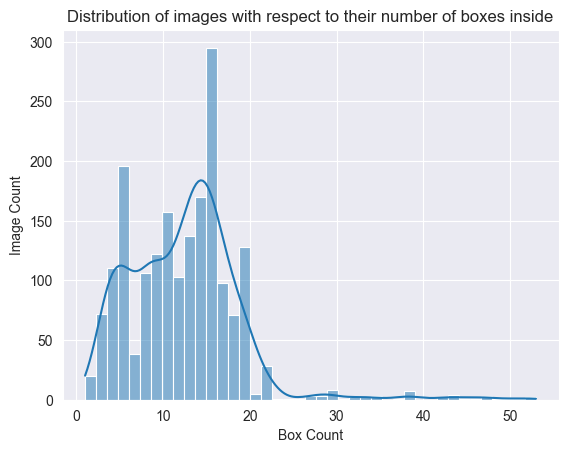

In [5]:
dataset_boxes = boxes_df('../NAPLab-LiDAR/new_labels')

sns.histplot(dataset_boxes.groupby('frame')['classID'].agg(len), kde=True)
plt.xlabel('Box Count')
plt.ylabel('Image Count')
plt.title('Distribution of images with respect to their number of boxes inside')
plt.show()

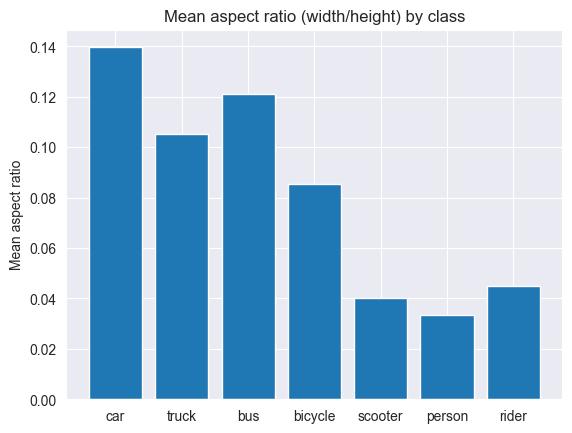

In [6]:
dataset_boxes['aspect_ratio'] = dataset_boxes.width/dataset_boxes.height
dataset_boxes['boxes_area'] = dataset_boxes.width*dataset_boxes.height
mean_aspect_ratio_by_class = dataset_boxes.groupby('classID')['aspect_ratio'].mean()
plt.bar(mean_aspect_ratio_by_class.index, mean_aspect_ratio_by_class.values)
plt.xticks(list(range(7)),labels=class_names)
plt.ylabel('Mean aspect ratio')
plt.title('Mean aspect ratio (width/height) by class')
plt.show()

basically all classes have vertical bb

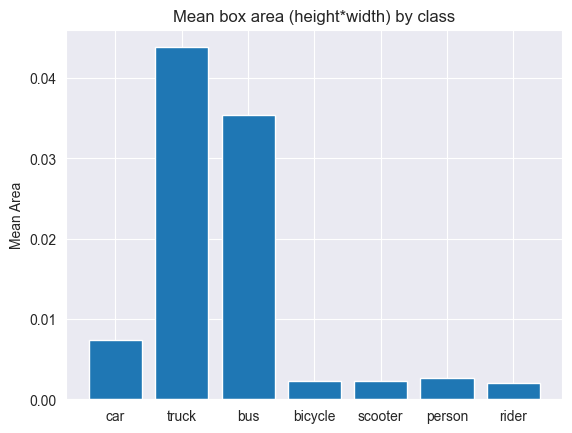

In [7]:
mean_box_areas_by_class = dataset_boxes.groupby('classID')['boxes_area'].mean()
plt.bar(mean_box_areas_by_class.index, mean_box_areas_by_class.values)
plt.xticks(list(range(7)),labels=class_names)
plt.ylabel('Mean Area')
plt.title('Mean box area (height*width) by class')
plt.show()

big objects have bigger boxes areas, make sense too

In [8]:
splitted_path = 'C:\\Users\\menbu\\PycharmProjects\\dlProject\\NAPLab-LiDAR\\splitted'

In [9]:
path = splitted_path
train_labels_path = f"{path}\\labels\\train\\"
val_labels_path = f"{path}\\labels\\val\\"
test_labels_path = f"{path}\\labels\\test\\"

train_df = boxes_df(train_labels_path)
val_df = boxes_df(val_labels_path)
test_df = boxes_df(test_labels_path)

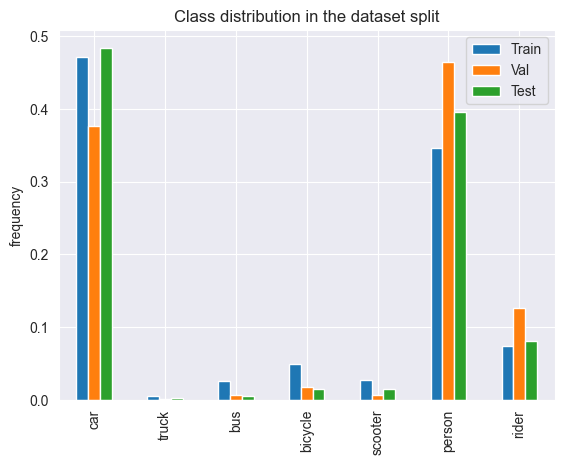

In [10]:
classes_by_set = pd.concat((train_df.classID, val_df.classID, test_df.classID), axis=1, ignore_index=True)
count_class_by_set = classes_by_set.apply(lambda col: col.value_counts(), axis=0)
normalized_count = count_class_by_set.div(count_class_by_set.sum(axis=0), axis=1)
normalized_count.rename(
    columns={0: "Train", 1: "Val", 2: "Test"},
    inplace=True)
normalized_count.plot(kind='bar')
plt.xticks(list(range(7)), class_names)
plt.ylabel('frequency')
plt.title('Class distribution in the dataset split')
plt.show()

## Plotting ground truth 

In [11]:
from PIL import Image, ImageDraw
from ultralytics.utils.plotting import Colors

In [12]:
interesting_pictures = ['frame_001678', 'frame_001555']

In [46]:
def get_img_with_boxes(frame_name):
    boxes = (
    dataset_boxes.groupby('frame')
    .get_group(frame_name+'.txt')
    .drop(columns=['frame']))
    return boxes, Image.open(f'../NAPLab-LiDAR/images/{frame_name}.PNG')

def draw_ground_truth(boxes, image ):
    
    colors = Colors()
    
    draw = ImageDraw.Draw(image)
    w = image.width
    h = image.height
    for _, box in boxes.iterrows():
        
        classID = int(box.classID)
    
        tw, th = box.width*w, box.height*h
        x1 = box.x*w - tw/2
        y1 = box.y*h - th/2
        x2 = box.x*w + tw/2
        y2 = box.y*h + th/2 
        
        
        name = class_names[classID]
        text_bbox = draw.textbbox((0, 0), name)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        text_x = (x1 + x2 - text_width) // 2
        text_y = y1 - text_height - 5  # Adjusted to place the text above the rectangle
        
        bg_width = text_width + 10  # Add some padding
        bg_height = text_height + 5  # Add some padding
        bg_x1 = text_x - 5  # Adjusted position for padding
        bg_y1 = text_y - 2  # Adjusted position for padding
        bg_x2 = bg_x1 + bg_width
        bg_y2 = bg_y1 + bg_height
        
        
        color = colors(classID)
        
        draw.rectangle((x1,y1,x2,y2), width=1, outline=color)
        draw.rectangle((bg_x1, bg_y1, bg_x2, bg_y2), fill=color)   
        draw.text((text_x, text_y), name, fill='white')
        
    return image

def display_labels(frame_name, predicted_path=None):
    
    print(f"Original image, ground truth{', predictions' if predicted_path is not None else ''}")
    
    b,i = get_img_with_boxes(frame_name)
    display(i)
    display(draw_ground_truth(b,i))
    if predicted_path is not None:
        display(Image.open(predicted_path))

## Unlabelled bycicles and persons

Original image, ground truth


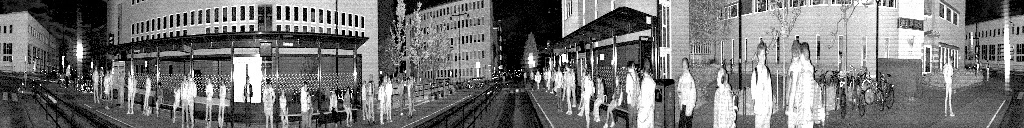

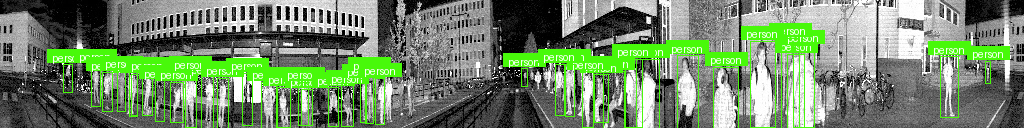

In [47]:
display_labels(interesting_pictures[0])

## Misslabeled Truck as Car and person as rider ( but still detected by m_1024_rect_nomos )

Original image, ground truth, predictions


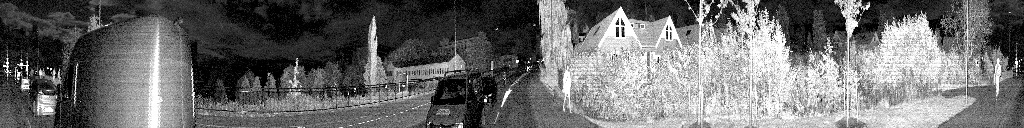

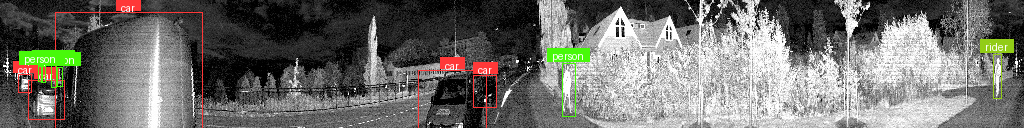

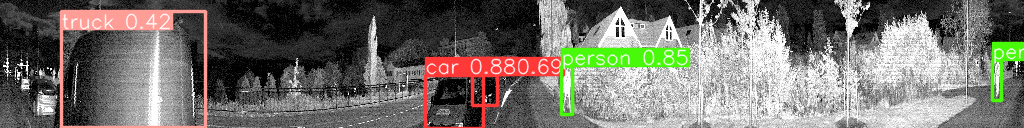

In [48]:
display_labels(
    interesting_pictures[1],
    'C:\\Users\\menbu\\PycharmProjects\\dlProject\\runs\\detect\\predict\\frame_001555.PNG'
)

## Misslabeled truck and unlabelled cars ( results from m_1024_rect_nomos)

Original image, ground truth, predictions


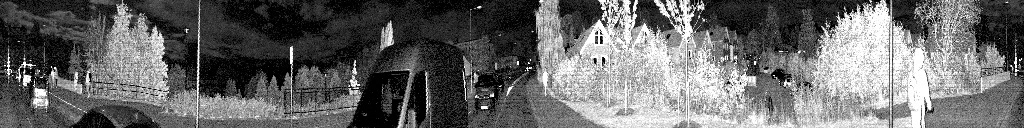

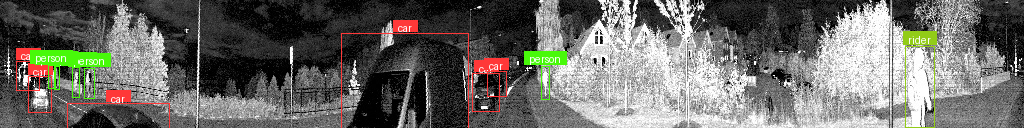

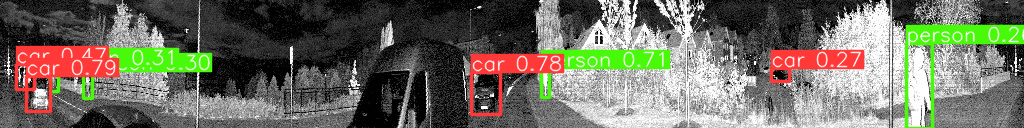

In [49]:
display_labels(
    'frame_001548',
    'C:\\Users\\menbu\\PycharmProjects\\dlProject\\runs\\detect\\predict\\frame_001548.PNG'
)